<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF285 - Computación Científica </h1>
    <h2> BVP and IVP </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.01</h2>
</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/Bonus%20-%20current/Bonus%20-%2009%20-%20BVP%20and%20IVP.ipynb)

<div id='toc' />

## Table of Contents
* [Acknowledgements](#acknowledgements)

# No debe utilizar bibliotecas adicionales.

In [1]:
import numpy as np
import scipy as sp
# To solve IVP, notice this is different that odeint!
from scipy.integrate import solve_ivp
# To integrate use one of the followings:
from scipy.integrate import quad, quadrature, trapezoid, simpson
# For least-square problems
from scipy.sparse.linalg import lsqr
from scipy.linalg import qr
# For interpolation
from scipy.interpolate import BarycentricInterpolator
# The wonderful GMRes
from scipy.sparse.linalg import gmres
# The wonderful**2 Newton method coupled to GMRes by a matrix-free call!
from scipy.optimize import newton_krylov
from scipy.optimize import root
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from ipywidgets import interact
from colorama import Fore, Back, Style
# https://pypi.org/project/colorama/
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL

# Shooting Method

## First example: Linear BVP

\begin{align*}
	a(x)\,y''(x)+b(x)\,y'(x)+c(x)\,y(x)&=f(x), \,\, \text{para } x\in]0,L[,\\
	y(0)&=u_0,\\
	y(L)&=u_L.
\end{align*}

In [2]:
# RHS of dynamical system
def my_f1(t,y,a,b,c,f):
    y1 = y[0]
    y2 = y[1]
    y1dot = y2
    y2dot = (f(t)-b(t)*y2-c(t)*y1)/a(t)
    return np.array([y1dot,y2dot])

# Function to be used to apply the Shooting Method
def F_SM_1(alpha,a,b,c,f,u0,uL,L,N):
    t = np.linspace(0,L,N)
    initial_condition = np.zeros(2)
    initial_condition[0] = u0
    initial_condition[1] = alpha
    sol = solve_ivp(my_f1,(0,L),initial_condition,t_eval=t,args=(a,b,c,f))
    # plt.plot(sol.t,sol.y[0,:],'-',label=str(alpha))
    return sol.y[0,-1]-uL

a = lambda x: np.power(x,2.)+1.
b = lambda x: x
c = lambda x: np.sin(10.*x)
f = lambda x: np.cos(x)

# Data definition
N=100
L=10
x = np.linspace(0,L,N)
u0 = 0.
uL = 1.

/var/folders/9y/fwh0nfx16wd6199vf_40_xkr0000gn/T/ipykernel_3396/3137237230.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_condition[1] = alpha


 message: The solution converged.
 success: True
  status: 1
     fun: -2.731148640577885e-14
       x: [-1.806e-01]
  method: hybr
    nfev: 11
    fjac: [[-1.000e+00]]
       r: [-6.145e+00]
     qtf: [-1.565e-10]
alpha_r -0.18060697531959374


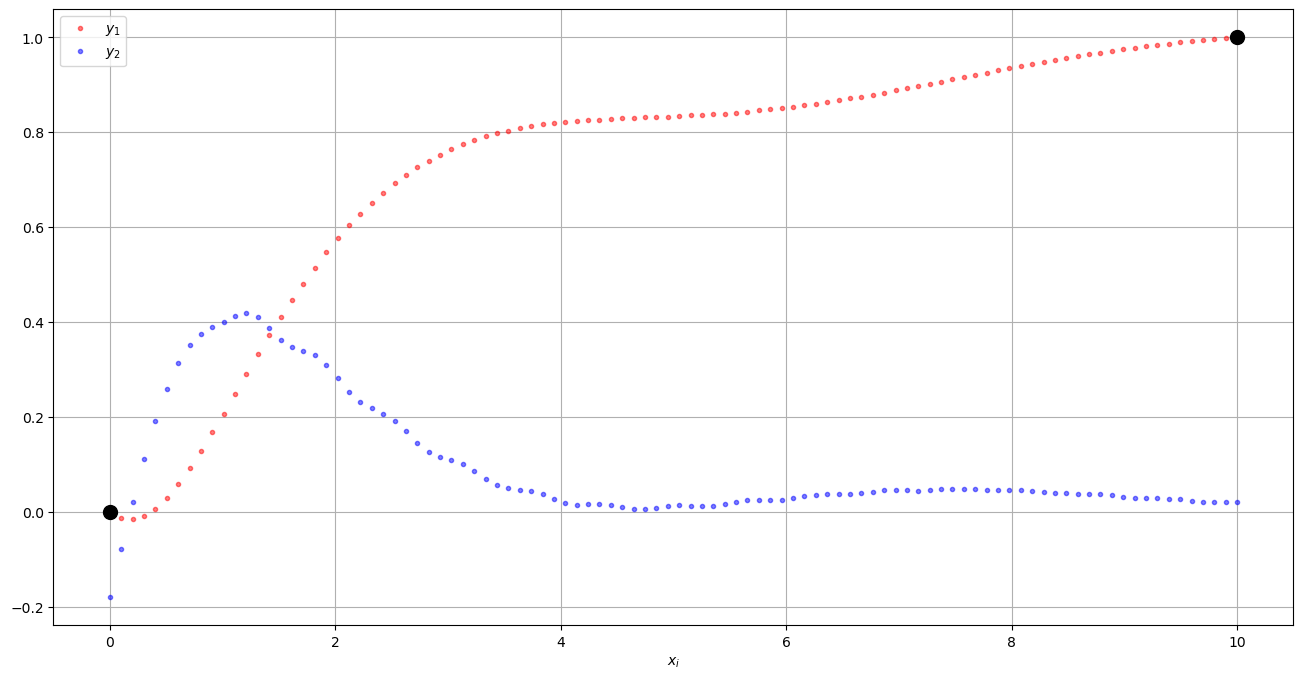

In [3]:
F_root_1 = lambda alpha: F_SM_1(alpha,a,b,c,f,u0,uL,L,N)
out = root(F_root_1, 1.)
# plt.legend(loc='best')
# plt.grid(True)
print(out)
alpha_r = out.x[0]
print('alpha_r',alpha_r)

sol = solve_ivp(my_f1,(0,L),np.array([u0,alpha_r]),t_eval=x,args=(a,b,c,f))
#print(sol)

plt.figure(figsize=(16,8))
plt.plot(sol.t,sol.y[0,:],'r.',label='$y_1$',alpha=0.5)
plt.plot(sol.t,sol.y[1,:],'b.',label='$y_2$',alpha=0.5)
plt.plot(np.array([0,L]),np.array([u0,uL]),'.k',markersize=20)
plt.legend(loc='best')
plt.xlabel(r'$x_i$')
plt.grid(True)
plt.show()

## Second example: Nonlinear BVP

\begin{align*}
	y''(x)+\left(y'(x)\right)^2+\sin(y(x))&=f(x), \,\, \text{para } x\in]0,L[,\\
	y(0)&=u_0,\\
	y(L)&=u_L,
\end{align*}

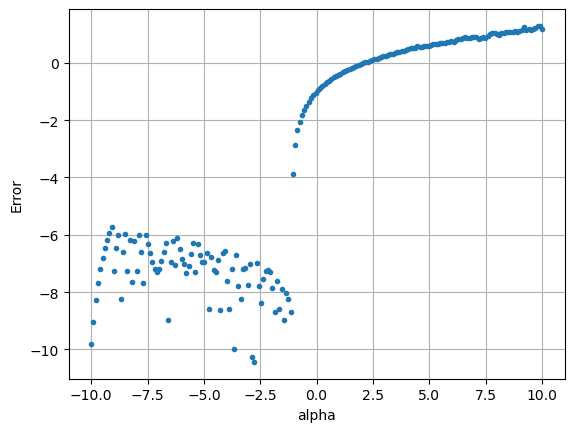

In [4]:
# RHS of dynamical system
def my_f2(t,y,f):
    y1 = y[0]
    y2 = y[1]
    y1dot = y2
    y2dot = f(t)-np.power(y2,2.0)-np.sin(y1)
    return np.array([y1dot,y2dot])

# Function to be used to apply the Shooting Method
def F_SM_2(alpha,f,y0,yL,L,N):
    t = np.linspace(0,1,N)
    initial_condition = np.zeros(2)
    initial_condition[0] = y0
    initial_condition[1] = alpha
    sol = solve_ivp(my_f2,(0,L),initial_condition,t_eval=t,args=(f,))
    return sol.y[0,-1]-yL

f = lambda x: np.cos(100.*x)

# Data definition
N=1000
L=1.
x = np.linspace(0,L,N)
y0 = 0.
yL = 1.

K = 200
alphas = np.linspace(-10,10,K)
error = np.zeros(K)
for k in np.arange(K):
    error[k]=F_SM_2(alphas[k],f,y0,yL,L,N)
plt.figure()
plt.plot(alphas,error,'.')
plt.xlabel('alpha')
plt.ylabel('Error')
plt.grid()
plt.show()
    

/var/folders/9y/fwh0nfx16wd6199vf_40_xkr0000gn/T/ipykernel_3396/2300476337.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  initial_condition[1] = alpha


 message: The solution converged.
 success: True
  status: 1
     fun: 5.10702591327572e-15
       x: [ 2.118e+00]
  method: hybr
    nfev: 10
    fjac: [[-1.000e+00]]
       r: [-4.273e-01]
     qtf: [ 2.026e-10]
alpha_r 2.118062044466451


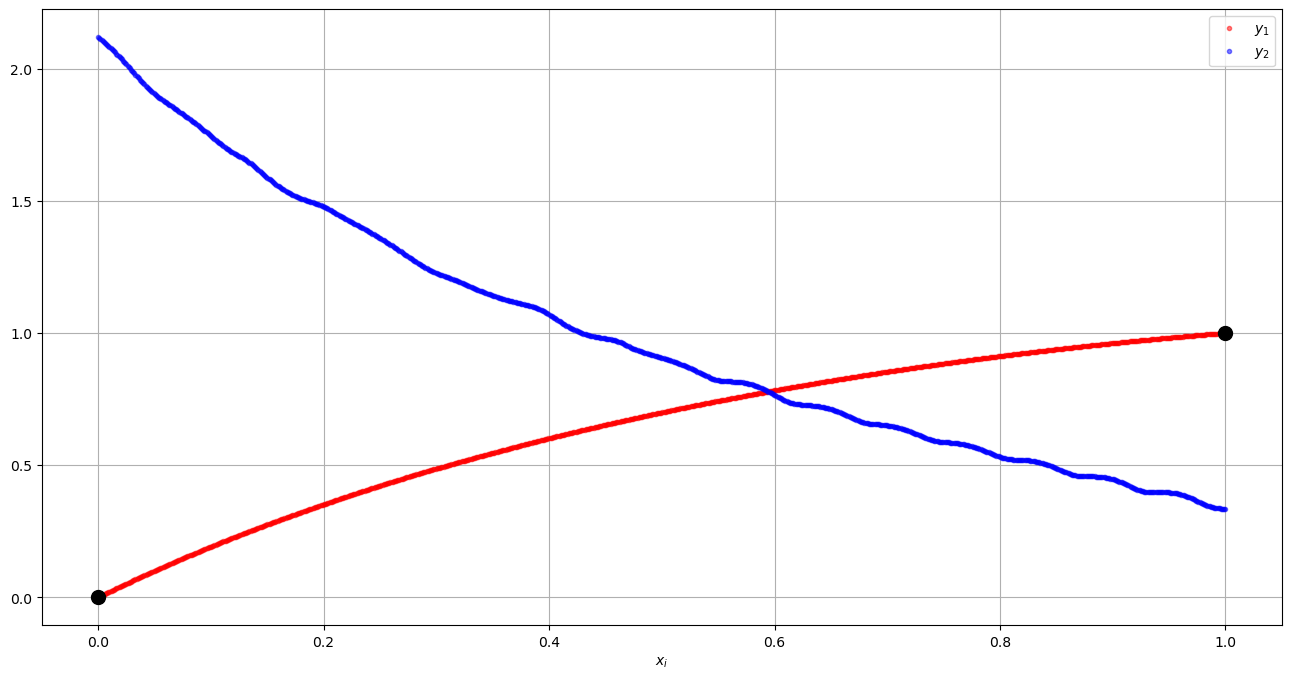

In [5]:
F_root_2 = lambda alpha: F_SM_2(alpha,f,y0,yL,L,N)
out = root(F_root_2, 2.5)
print(out)
alpha_r = out.x[0]
print('alpha_r',alpha_r)

sol = solve_ivp(my_f2,(0,L),np.array([y0,alpha_r]),t_eval=x,args=(f,))

plt.figure(figsize=(16,8))
plt.plot(sol.t,sol.y[0,:],'r.',label='$y_1$',alpha=0.5)
plt.plot(sol.t,sol.y[1,:],'b.',label='$y_2$',alpha=0.5)
plt.plot(np.array([0,L]),np.array([y0,yL]),'.k',markersize=20)
plt.legend(loc='best')
plt.xlabel(r'$x_i$')
plt.grid(True)
plt.show()

# Finite Difference Method

## First example: Linear BVP

\begin{align*}
	a(x)\,y''(x)+b(x)\,y'(x)+c(x)\,y(x)&=f(x), \,\, \text{para } x\in]0,L[,\\
	y(0)&=u_0,\\
	y(L)&=u_L,
\end{align*}

Consider that $x_i = i\,\frac{L}{N}$ for $i\,\{0,1,\dots,N\}$, and $y(x_i) \approx w_i$, where we know that $w_{0}=u_0$ and $w_{N}=u_L$.
For simplicity we will consider $\mathbf{w}=[w_1,w_2,\dots,w_{N-1}]$.
The finite diference discretizations that we will use are the followings:
\begin{align*}
    y''(x_i) &\approx \dfrac{w_{i+1}-2\,w_i+w_{i-1}}{h^2},\\
    y'(x_i)  &\approx \dfrac{w_{i+1}-w_{i-1}}{2\,h}.
\end{align*}
Thus, the discrete version of the ode at $x_i$ will be the following:
\begin{align*}
    a(x_i)\,y''(x_i)      &\approx a(x_i)\,\dfrac{w_{i+1}-2\,w_i+w_{i-1}}{h^2},\\
    b(x_i)\,y'(x_i)  &\approx b(x_i)\,\dfrac{w_{i+1}-w_{i-1}}{2\,h},\\
    c(x_i)\,y(x_i)   &\approx c(x_i)\,w_i,\\
    f(x_i)           &\approx f(x_i).
\end{align*}
By using the unknowns vector $\mathbf{w}$ and the known vector $\mathbf{x}=[x_1,x_2,\dots,x_{N-1}]$ we can define the following matrices:
\begin{align*}
    D_2 &= 
    \begin{bmatrix}
        -2 &  1 & 0 & 0 & 0 & 0 & 0 \\
         1 & -2 & 1 & 0 & 0 & 0 & 0 \\
         0 &  1 & -2 & 1 & 0 & 0 & 0 \\
         \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots \\
         0 &  0 & 0 & 0 & 1 & -2 & 1 \\
         0 &  0 & 0 & 0 & 0 & 1 & -2 \\
    \end{bmatrix},\\
    D  &= 
    \begin{bmatrix}
         0 & 1 & 0 & 0 & 0 & 0 & 0 \\
         -1 & 0 & 1 & 0 & 0 & 0 & 0 \\
         0 &  -1 & 0 & 1 & 0 & 0 & 0 \\
         \vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \ddots \\
         0 &  0 & 0 & 0 & -1 & 0 & 1 \\
         0 &  0 & 0 & 0 & 0 & -1 & 0 \\
    \end{bmatrix}.\\
\end{align*}

In [6]:
# This function builds the h-less differentiation matrices for
# the approximation of the first and second derivatives.
# h-less means that it still needs to add the corresponding
# h coefficient in the approximation.
def build_D_D2_and_Dt_D2t(M):
    # First derivative - Central difference differentiation matrix
    D  = toeplitz(np.append(np.array([0, -1.]), np.zeros(M-2)), 
                     np.append(np.array([0, 1.]), np.zeros(M-2)))
    Dt = toeplitz(np.append(np.array([-1.]), np.zeros(M-1)),np.append(np.array([-1,0, 1.]), np.zeros(M-1))) 
    # Second derivative - differentiation matrix
    D2 = toeplitz(np.append(np.array([-2, 1.]), np.zeros(M-2)))
    D2t = toeplitz(np.append(np.array([1.]), np.zeros(M-1)),np.append(np.array([1,-2, 1.]), np.zeros(M-1)))
    return D, D2, Dt, D2t
D , D2, Dt, D2t = build_D_D2_and_Dt_D2t(5)
print('D: \n', D)
print('D2: \n', D2)
print('Dt: \n', Dt)
print('D2t: \n', D2t)

D: 
 [[ 0.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0.  0. -1.  0.  1.]
 [ 0.  0.  0. -1.  0.]]
D2: 
 [[-2.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -2.]]
Dt: 
 [[-1.  0.  1.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  0.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.  0.]
 [ 0.  0.  0. -1.  0.  1.  0.]
 [ 0.  0.  0.  0. -1.  0.  1.]]
D2t: 
 [[ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]]


The discrete equation at $x_i$ is the following:
\begin{equation*}
    \dfrac{a(x_i)}{h^2} \left(w_{i+1}-2\,w_i+w_{i-1}\right)
    +
    \dfrac{b(x_i)}{2\,h} \left(w_{i+1}-w_{i-1}\right)
    +
    c(x_i)\,w_i
    =
    f(x_i).
\end{equation*}
There are two special cases, for $x_1$ and $x_{N-1}$, they generate the following equations:
\begin{align*}
    \dfrac{a(x_1)}{h^2} \left(w_{2}-2\,w_1+w_0\right)
    +
    \dfrac{b(x_1)}{2\,h} \left(w_{2}-w_0\right)
    +
    c(x_1)\,w_1
    &=
    f(x_1),\\
    \dfrac{a(x_{N-1})}{h^2} \left(w_{N}-2\,w_{N-1}+w_{N-2}\right)
    +
    \dfrac{b(x_{N-1})}{2\,h} \left(w_{N}-w_{N-2}\right)
    +
    c(x_{N-1})\,w_{N-1}
    &=
    f(x_{N-1}).
\end{align*}
But, since we know $w_0$ and $w_{N}$, they become,
\begin{align*}
    \dfrac{a(x_1)}{h^2} \left(w_{2}-2\,w_1\right)
    +
    \dfrac{b(x_1)}{2\,h} w_{2}
    +
    c(x_1)\,w_1
    &=
    f(x_1)-\dfrac{a(x_1)}{h^2} w_0+\dfrac{b(x_0)}{2\,h}\,w_0,\\
    \dfrac{a(x_{N-1})}{h^2} \left(-2\,w_{N-1}+w_{N-2}\right)
    +
    \dfrac{b(x_{N-1})}{2\,h} \left(-w_{N-2}\right)
    +
    c(x_{N-1})\,w_{N-1}
    &=
    f(x_{N-1})-\dfrac{a(x_{N-1})}{h^2}\,w_{N}-\dfrac{b(x_{N-1})}{2\,h}\,w_{N}.
\end{align*}
This analysis allows us to write the discrete equation in the following way for the unknown vector $\mathbf{w}=[w_1,w_2,\dots,w_{N-1}]$ and $\mathbf{x}=[x_1,x_2,\dots,x_{N-1}]$:
\begin{equation*}
    \dfrac{1}{h^2}\,\text{diag}(a(\mathbf{x}))\,D_2\,\mathbf{w}
    +
    \dfrac{1}{2\,h}\,\text{diag}(b(\mathbf{x}))\,D\,\mathbf{w}
    +
    \text{diag}(c(\mathbf{x}))\,\mathbf{w}
    =
    \begin{bmatrix}
        f(x_1)-\dfrac{a(x_1)}{h^2} w_0+\dfrac{b(x_1)}{2\,h}\,w_0\\
        f(x_2)\\
        \vdots\\
        f(x_{N-2})\\
        f(x_{N-1})-\dfrac{a(x_{N-1})}{h^2}\,w_{N}-\dfrac{b(x_{N-1})}{2\,h}\,w_{N}
    \end{bmatrix},
\end{equation*}
but since $w_0=u_0$ and $w_{N}=u_L$ we get,
\begin{equation*}
    \dfrac{1}{h^2}\,\text{diag}(a(\mathbf{x}))\,D_2\,\mathbf{w}
    +
    \dfrac{1}{2\,h}\,\text{diag}(b(\mathbf{x}))\,D\,\mathbf{w}
    +
    \text{diag}(c(\mathbf{x}))\,\mathbf{w}
    =
    \begin{bmatrix}
        f(x_1)-\dfrac{a(x_1)}{h^2} u_0+\dfrac{b(x_1)}{2\,h}\,u_0\\
        f(x_2)\\
        \vdots\\
        f(x_{N-2})\\
        f(x_{N-1})-\dfrac{a(x_{N-1})}{h^2}\,u_L-\dfrac{b(x_{N-1})}{2\,h}\,u_L
    \end{bmatrix},
\end{equation*}
Factoring out the unknown vector $\mathbf{w}$ we obtain,
\begin{align*}
    \underbrace{\left(\dfrac{1}{h^2}\,\text{diag}(a(\mathbf{x}))\,D_2
    +
    \dfrac{1}{2\,h}\,\text{diag}(b(\mathbf{x}))\,D
    +
    \text{diag}(c(\mathbf{x}))\right)}_{\displaystyle{A_N}}\,\mathbf{w}
    &=\mathbf{b}_N.
\end{align*}
Thus, we only need to solve now the linear system of equations $A_N\,\mathbf{w}=\mathbf{b}$ and we are done!
Notice that the sub-index in $A_N$ is just to indicate we have a discretization with $N$ points.

**Notice that we moved from the discrete equations 
$\dfrac{a(x_i)}{h^2} \left(w_{i+1}-2\,w_i+w_{i-1}\right)+
    \dfrac{b(x_i)}{2\,h} \left(w_{i+1}-w_{i-1}\right)
    +
    c(x_i)\,w_i
    =
    f(x_i)$  to the matrix equations $\dfrac{1}{h^2}\,\text{diag}(a(\mathbf{x}))\,D_2\,\mathbf{w}
    +
    \dfrac{1}{2\,h}\,\text{diag}(b(\mathbf{x}))\,D\,\mathbf{w}
    +
    \text{diag}(c(\mathbf{x}))\,\mathbf{w}
    =\mathbf{b}_N$, however it is recommended to perform this step, at least for an small problem, manually so it can be understood better. Thus we encourage to do this, for instance for $N=7$.**

In [7]:
# Data definition
a = lambda x: np.power(x,2.)+1.
b = lambda x: x
c = lambda x: np.sin(10.*x)
f = lambda x: np.cos(x)

# Data definition
N=100
L=10
x = np.linspace(0,L,N)
h = x[1]-x[0]
y0 = 0.
yL = 1.

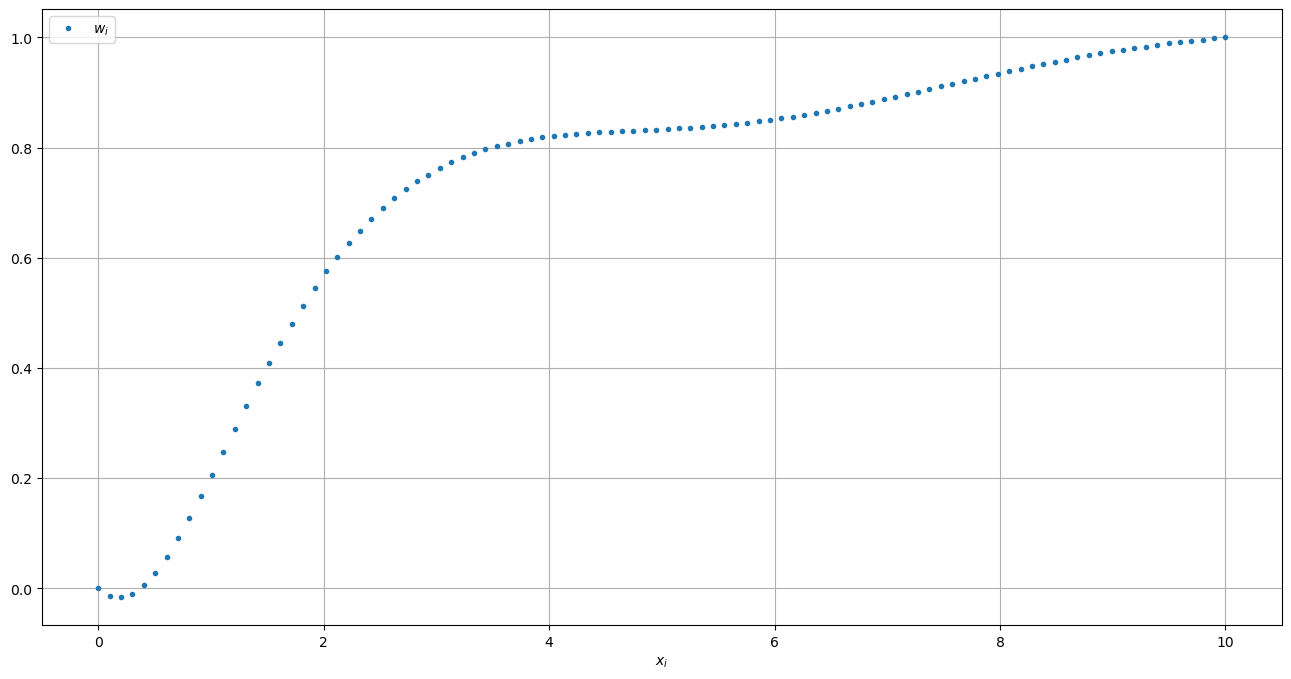

In [8]:
def build_A_and_b(a,b,c,f,h,x,y0,yL,N):
    D, D2, _, _ = build_D_D2_and_Dt_D2t(N-2)
    x_interior = x[1:-1]
    A_N=(1./(h**2))*np.dot(np.diag(a(x_interior)),D2)+(1./(2*h))*np.dot(np.diag(b(x_interior)),D)+np.diag(c(x_interior))
    b_N = f(x_interior)
    b_N[0] = b_N[0]-(a(x_interior[0])/(h**2))*y0+(b(x_interior[0])/(2*h))*y0
    b_N[-1] = b_N[-1]-(a(x_interior[-1])/(h**2))*yL-(b(x_interior[-1])/(2*h))*yL
    return A_N, b_N

A_N, b_N = build_A_and_b(a,b,c,f,h,x,y0,yL,N)
w = np.linalg.solve(A_N,b_N)
w = np.append(y0,w)
w = np.append(w,yL)

plt.figure(figsize=(16,8))
plt.plot(x,w,'.',label=r'$w_i$')
plt.xlabel(r'$x_i$')
plt.grid(True)
plt.legend(loc='best')
plt.show()

## Second example: Nonlinear BVP

\begin{align*}
	y''(x)+\left(y'(x)\right)^2+\sin(y(x))&=f(x), \,\, \text{para } x\in]0,L[,\\
	y(0)&=u_0,\\
	y(L)&=u_L,
\end{align*}

In this case we will re-use $D_2$ from the previous analysis, so the discrete equation becomes:
The discrete equation at $x_i$ is the following:
\begin{equation*}
    \dfrac{1}{h^2} \left(w_{i+1}-2\,w_i+w_{i-1}\right)
    +
    \left(\dfrac{w_{i+1}-w_{i-1}}{2\,h}\right)^2
    +
    \sin(w_i)
    =
    f(x_i).
\end{equation*}
There are two special cases, for $x_1$ and $x_{N-1}$, they generate the following equations:
\begin{align*}
    \dfrac{1}{h^2} \left(w_{2}-2\,w_1+w_{0}\right)
    +
    \left(\dfrac{w_{2}-w_{0}}{2\,h}\right)^2
    +
    \sin(w_1)
    &=
    f(x_2).\\
    \dfrac{1}{h^2} \left(w_{N}-2\,w_{N-1}+w_{N-2}\right)
    +
    \left(\dfrac{w_{N}-w_{N-2}}{2\,h}\right)^2
    +
    \sin(w_{N-1})
    &=
    f(x_{N-1}).
\end{align*}
But, since we know $w_0$ and $w_{N}$, they become,
\begin{align*}
    \dfrac{1}{h^2} \left(w_{2}-2\,w_1\right)
    +
    \left(\dfrac{w_{2}-w_{0}}{2\,h}\right)^2
    +
    \sin(w_1)
    &=
    f(x_2)-\dfrac{w_0}{h^2},\\
    \dfrac{1}{h^2} \left(w_{2}-2\,w_1\right)
    +
    \dfrac{w_{2}^2-2\,w_{2}\,w_{0}+w_{0}^2}{4\,h^2}
    +
    \sin(w_1)
    &=
    f(x_2)-\dfrac{w_0}{h^2},\\
    \dfrac{1}{h^2} \left(w_{2}-2\,w_1\right)
    +
    \dfrac{w_{2}^2-2\,w_{2}\,w_{0}}{4\,h^2}
    +
    \sin(w_1)
    &=
    f(x_2)-\dfrac{w_0}{h^2}-\dfrac{w_{0}^2}{4\,h^2}.
\end{align*}
and
\begin{align*} 
    \dfrac{1}{h^2} \left(w_{N}-2\,w_{N-1}+w_{N-2}\right)
    +
    \left(\dfrac{w_{N}-w_{N-2}}{2\,h}\right)^2
    +
    \sin(w_{N-1})
    &=
    f(x_{N-1}),\\
    \dfrac{1}{h^2} \left(w_{N}-2\,w_{N-1}+w_{N-2}\right)
    +
    \dfrac{w_{N}^2-2\,w_{N}\,w_{N-2}+w_{N-2}^2}{4\,h^2}
    +
    \sin(w_{N-1})
    &=
    f(x_{N-1})\\
    \dfrac{1}{h^2} \left(-2\,w_{N-1}+w_{N-2}\right)
    +
    \dfrac{-2\,w_{N}\,w_{N-2}+w_{N-2}^2}{4\,h^2}
    +
    \sin(w_{N-1})
    &=
    f(x_{N-1})-\dfrac{w_{N}}{h^2}-\dfrac{w_{N}^2}{4\,h^2}
\end{align*}
This analysis allows us to write the discrete equation in the following way for the unknown vector $\mathbf{w}=[w_1,w_2,\dots,w_{N-1}]$ and $\mathbf{x}=[x_1,x_2,\dots,x_{N-1}]$:
\begin{equation*}
    \dfrac{1}{h^2}\,\widehat{D}_2\,\widehat{\mathbf{w}}
    +
    \dfrac{1}{4\,h^2}\,\left(\widehat{D}\,\widehat{\mathbf{w}}\right)^2
    +
    \sin(\mathbf{w})
    =
    f(\mathbf{x}).
\end{equation*}
In this case we can't factor out the unknown vector $\mathbf{w}$ since it is not a linear problem.
We need to ask for help to _Sir Isaac Newton_ and to _Professor Aleksey Nikolaevich Krylov_!
For simplicity we will build $\mathbf{F}(\mathbf{w})$, i.e. the high dimensional function that we need to find the root.
\begin{equation*}
    \mathbf{F}(\mathbf{w})=
    \dfrac{1}{h^2}\,\widehat{D}_2\,\widehat{\mathbf{w}}
    +
    \dfrac{1}{4\,h^2}\,\left(\widehat{D}\,\widehat{\mathbf{w}}\right)^2
    +
    \sin(\mathbf{w})
    -
    f(\mathbf{x})
\end{equation*}
To solve this equation we will use _newton_krylov_!

In [9]:
f = lambda x: np.cos(100.*x)

# Data definition
N=100
L=1.
x = np.linspace(0,L,N)
h = x[1]-x[0]
y0 = 0.
yL = 1.

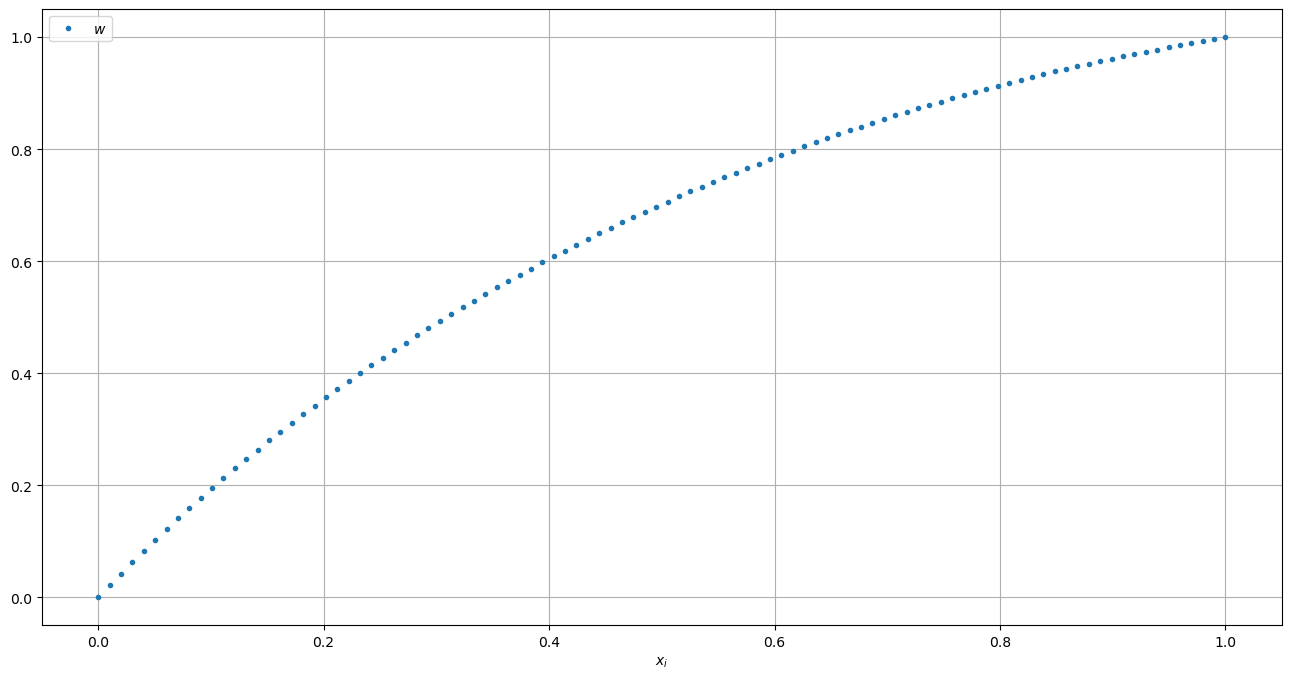

In [10]:
D, D2, Dt, D2t = build_D_D2_and_Dt_D2t(N-2)
def F(w):
    wt = np.concatenate(([y0], w, [yL]), axis=0)
    return np.dot(D2t,wt)/(h**2)+np.power(np.dot(Dt,wt),2.0)/(4*(h**2))+np.sin(w)-f(x[1:-1])

w0 = lambda m: m*(x[1:-1]-np.power(x[1:-1],2))
# First solution
w = newton_krylov(F,w0(0))
w = np.concatenate(([y0],w, [yL]),axis=0)


plt.figure(figsize=(16,8))
plt.plot(x,w,'.',label=r'$w$')
plt.legend(loc='best')
plt.xlabel(r'$x_i$')
plt.grid(True)
plt.show()

<div id='acknowledgements' />

# Acknowledgements
[Back to toc](#toc)

* _Material originally created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) _. DI UTFSM. November 2023._
* _Update March 2025 - v1.01 - C.Torres_ : Adding Colab link.